In [1]:
from collections import defaultdict, Counter
from multiprocessing import Pool
from pathlib import Path
from typing import Dict
import json
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from consent.consistency.cookie_match import cookie_pref_match
from consent.data.site_pref import read_site_prefs
from consent.data.postrej_cookie_reader import parallel_read_postrej_sent_cookies
from consent.util.default_path import get_data_dir
from ooutil.cookie_util import get_brower_cookies, parse_cookie_str, url_domain_match
from ooutil.type_util import hashabledict
from ooutil.url_util import get_suffixed_domain


# data_dir = get_data_dir('2021-04-27/pref_menu_scan')
# data_dir = get_data_dir('2021-04-28/pref_menu_scan')
# data_dir = get_data_dir('2021-04-30/pref_menu_scan')
data_dir = get_data_dir('2021-05-01/pref_menu_scan')
data_dir = get_data_dir('2021-05-03/pref_menu_scan_cleanstart')

fig_dir = Path.home() / 'local_projects/consent/paper/sp22/figures'
assert fig_dir.exists() and fig_dir.is_dir()

In [2]:
scanned_sites = [site_dir.name for site_dir in data_dir.glob('*') if site_dir.is_dir()]
site_dirs = [data_dir / site for site in scanned_sites]
print("Number of scanned sites:", len(scanned_sites)) # , scanned_sites)
site_prefs = read_site_prefs(site_dirs)
site_prefs

Number of scanned sites: 227
Contain duplicates: Before 12937, after drop duplicates: 12927


,duration,host,name,group_id,site,consent
0,Session,healthgrades.com,_vapi,C0001,healthgrades.com,True
1,365 days,partners.healthgrades.com,OptanonConsent,C0001,healthgrades.com,True
2,a few seconds,healthgrades.com,_dc_gtm_UA-xxxxxxxx,C0001,healthgrades.com,True
3,2914169 days,partners.healthgrades.com,eupubconsent,C0001,healthgrades.com,True
4,365 days,healthgrades.com,OptanonAlertBoxClosed,C0001,healthgrades.com,True
...,...,...,...,...,...,...
12932,390 days,yieldoptimizer.com,ph,SPD_BG,bestwestern.com,False
12933,390 days,yieldoptimizer.com,dph,SPD_BG,bestwestern.com,False
12934,390 days,yieldoptimizer.com,gcma,SPD_BG,bestwestern.com,False
12935,390 days,yieldoptimizer.com,ckid,SPD_BG,bestwestern.com,False


In [3]:
# site_prefs.sample(50)

In [4]:
cookielist_sites = sorted(site_prefs.site.unique().tolist())
n_cookielist_sites = len(cookielist_sites)
assert site_prefs.site.nunique() == n_cookielist_sites
print("Sites with cookie list:", n_cookielist_sites, cookielist_sites)

Sites with cookie list: 83 ['accorhotels.com', 'adtelligent.com', 'apachefriends.org', 'behance.net', 'bestwestern.com', 'biomedcentral.com', 'bitnami.com', 'bodybuilding.com', 'britishcouncil.org', 'callofduty.com', 'canon.com', 'cell.com', 'chanel.com', 'christies.com', 'cloudflare.com', 'cnet.com', 'commonsensemedia.org', 'corel.com', 'digicert.com', 'digitalspy.com', 'documentforce.com', 'download.com', 'elsevier.com', 'elsevierhealth.com', 'exacttarget.com', 'exoclick.com', 'fairmont.com', 'fendi.com', 'force.com', 'gamespot.com', 'glassdoor.co.in', 'glassdoor.com', 'goal.com', 'healthgrades.com', 'home.kpmg', 'hotjar.com', 'irishtimes.com', 'kpmg.com', 'magento.com', 'mango.com', 'marketo.com', 'mcdonalds.com', 'media.net', 'mendeley.com', 'metacritic.com', 'myportfolio.com', 'nature.com', 'netflix.com', 'news24.com', 'nflxvideo.net', 'oclc.org', 'onetrust.com', 'pardot.com', 'payoneer.com', 'pendo.io', 'rapidssl.com', 'redbull.com', 'rte.ie', 'salesforce.com', 'scientificamerica

In [5]:
raw_postrej_sent_cookies_file = data_dir / 'raw_postrej_sent_cookies.parquet'
if raw_postrej_sent_cookies_file.exists():
    raw_postrej_sent_cookies = pd.read_parquet(raw_postrej_sent_cookies_file)
else:
    raw_postrej_sent_cookies = parallel_read_postrej_sent_cookies(data_dir)
    raw_postrej_sent_cookies.to_parquet(raw_postrej_sent_cookies_file); print(f"Written to {raw_postrej_sent_cookies_file}")

raw_postrej_sent_cookies.head(3)

,domain,expires,httpOnly,name,path,sameSite,secure,value,request_url,site,load_start_time,load_end_time
0,.siemens.com,1.651627e+09,False,OptanonAlertBoxClosed,/,None,True,2021-05-04T01:24:38.671Z,https://www.siemens.com/css/chunk-618b9f60.9ae...,siemens.com,1.620091e+09,1.620091e+09
1,.siemens.com,-1.000000e+00,False,s_cc,/,None,False,true,https://www.siemens.com/js/chunk-b883de0a.ff4e...,siemens.com,1.620091e+09,1.620091e+09
2,.siemens.com,1.651627e+09,False,OptanonAlertBoxClosed,/,None,True,2021-05-04T01:24:38.671Z,https://www.siemens.com/js/chunk-0268bb8f.a48a...,siemens.com,1.620091e+09,1.620091e+09


In [6]:
postrej_sent_cookies = raw_postrej_sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'value', 'request_url', 'site']].drop_duplicates()
postrej_br_cookies = postrej_sent_cookies[['domain', 'expires', 'name', 'path', 'sameSite', 'secure', 'site']].drop_duplicates()

In [7]:
print(f"Num raw captured cookies: {len(raw_postrej_sent_cookies)}")
print(f"Num unique captured cookies: {len(postrej_sent_cookies)}")
print(f"Num unique browser cookies: {len(postrej_br_cookies)}")

Num raw captured cookies: 958458
Num unique captured cookies: 562571
Num unique browser cookies: 22177


## Analyze cookies compliance    

In [8]:
# Map intercepted cookies to browser cookies.
import sys; import importlib; importlib.reload(sys.modules['consent.cmp.comply.cookie_match'])
from consent.cmp.comply.cookie_match import cookie_pref_match

site_to_contras = {}  # TODO: make this to non-global one.

def check_in_set(site, acookie, cookie_pref_set, verbose=0):
    # check_url_host_match = relax_check_url_host_match # strict_check_url_host_match
    for cookie_pref in cookie_pref_set:
        if verbose >= 3:
            print(f'{cookie_pref=} {acookie=}')
        elif verbose >= 2:
            if cookie_pref['name'] == acookie['name']:
                print(f'{cookie_pref=} {acookie=}')
        
        if cookie_pref_match(acookie, cookie_pref, site):
            return True
    return False


def comply_check(site, acookie, appr_set, rej_set):
    is_appr = check_in_set(site, acookie, appr_set)
    is_rej = check_in_set(site, acookie, rej_set)
    if is_appr and not is_rej:
        return 'comply'
    elif not is_appr and is_rej:
        return 'incorrect'
    elif not is_appr and not is_rej:
        return 'omit'
    else:
        return 'ambiguous'


def get_appr_rej_sets(cookie_consents):
    """Return 2 sets: appr and rejection."""
    appr_set = set()
    rej_set = set()
    for _, row in cookie_consents.iterrows():
        cookie = {'host': row['host'], 'name': row['name']}
        cookie = hashabledict(cookie)
        if row['consent']:
            # assert cookie not in appr_set
            appr_set.add(cookie)
        else:
            # assert cookie not in rej_set
            rej_set.add(cookie)
    contra_set = appr_set.intersection(rej_set)

    return appr_set, rej_set, contra_set


def get_complies_for_site(site, prefs, sent_cookies):
    appr_set, rej_set, contra_set = get_appr_rej_sets(prefs)
    comply_results = []
    for sent_cookie in sent_cookies:
        comply = comply_check(site, sent_cookie, appr_set, rej_set)
        comply_result = sent_cookie.copy()
        comply_result.update({'comply': comply, 'site': site})
        comply_results.append(comply_result)
    if len(contra_set) > 0:
        print(f'Contradictory set: {site=} {contra_set=}')
    site_to_contras[site] = contra_set
    return comply_results


def get_complies(site_prefs, postrej_sent_cookies):
    comply_results = []
    for site in cookielist_sites:
        postrej_sent_cookies_for_site = postrej_sent_cookies[postrej_sent_cookies.site == site].to_dict('records')
        prefs_for_site = site_prefs[site_prefs.site == site]
        complies_for_site = get_complies_for_site(site, prefs_for_site, postrej_sent_cookies_for_site)
        comply_results.extend(complies_for_site)
    return pd.DataFrame(comply_results)

full_complies = get_complies(site_prefs, postrej_sent_cookies)
full_complies

Contradictory set: site='accorhotels.com' contra_set={{'host': 'ibis.accor.com', 'name': 'GoogleAdServingTest'}, {'host': 'restaurants.accor.com', 'name': 'GoogleAdServingTest'}, {'host': 'mercure.accor.com', 'name': 'GoogleAdServingTest'}, {'host': 'sofitel.accor.com', 'name': 'GoogleAdServingTest'}, {'host': 'pullman.accor.com', 'name': 'GoogleAdServingTest'}, {'host': 'google.com', 'name': 'NID'}, {'host': 'all.accor.com', 'name': 'GoogleAdServingTest'}, {'host': 'hotelf1.accor.com', 'name': 'GoogleAdServingTest'}}
Contradictory set: site='cell.com' contra_set={{'host': 'hubspot.net', 'name': '__cfduid'}}
Contradictory set: site='fairmont.com' contra_set={{'host': 'google.com', 'name': 'NID'}, {'host': 'google.com', 'name': 'CONSENT'}}
Contradictory set: site='glassdoor.com' contra_set={{'host': 'glassdoor.com', 'name': 'dc'}}
Contradictory set: site='myportfolio.com' contra_set={{'host': 'app-aba.marketo.com', 'name': '__cf_bm'}}
Contradictory set: site='oclc.org' contra_set={{'hos

,domain,expires,name,path,sameSite,secure,value,request_url,site,comply
0,.accor.com,-1.000000e+00,_Hw2h_,/,None,True,.s76b,https://all.accor.com/home/styles-v2104/styles...,accorhotels.com,comply
1,.accor.com,1.651628e+09,userPrefLocalization,/,None,False,en,https://all.accor.com/assets/icons/brands/logo...,accorhotels.com,incorrect
2,.accor.com,-1.000000e+00,JSESSIONID,/,None,True,0C6AA4EC8D0E92C8DB09130C7FABB876E821EB345334D2...,https://all.accor.com/fstrz/r/stats-euwest1.fz...,accorhotels.com,omit
3,.accor.com,1.622720e+09,tarssid,/,None,False,DIRECT_ACCESS,https://all.accor.com/assets/fonts/roboto/bold...,accorhotels.com,omit
4,.accor.com,-1.000000e+00,userBrowsingZoneLocalization,/,None,False,usa,https://all.accor.com/home/components/engine-h...,accorhotels.com,incorrect
...,...,...,...,...,...,...,...,...,...,...
206279,.zdnet.com,-1.000000e+00,zdnetSessionStarted,/,None,True,true,https://saa.zdnet.com/b/ss/cnetzdnetglobalsite...,zdnet.com,omit
206280,.zdnet.com,1.651628e+09,_pubcid,/,Lax,False,d0f289e7-a69b-458c-9620-4a83ebfda299,https://www.zdnet.com/a/hub/i/r/2021/05/03/1a0...,zdnet.com,omit
206281,.zdnet.com,1.622684e+09,arrowImp,/,None,True,true,https://www.zdnet.com/a/hub/i/r/2016/04/12/910...,zdnet.com,omit
206282,.zdnet.com,1.653788e+09,__gads,/,None,False,ID=6e926b81a15b58c6:T=1620091568:S=ALNI_MYCh6B...,https://www.zdnet.com/article/chegg-reaches-re...,zdnet.com,comply


In [9]:
complies = full_complies[ ['name', 'domain', 'site', 'comply',]].drop_duplicates()
comply_counts = complies.comply.value_counts()
# sns.barplot(x=comply_counts.index, y=comply_counts.values)
comply_counts

omit         1401
comply        772
incorrect     726
ambiguous      12
Name: comply, dtype: int64

In [10]:
comply_sites_data = defaultdict(list)
for comply_type, group in complies.groupby('comply'):
    comply_sites_data['comply_type'].append(comply_type)
    comply_sites_data['num_sites'].append(group.site.nunique())
comply_sites = pd.DataFrame(comply_sites_data).sort_values(by=['num_sites'], ascending=False)
comply_sites['num_sites_percent'] = comply_sites['num_sites'] / n_cookielist_sites * 100
comply_sites['num_cookies'] = comply_sites['comply_type'].map(comply_counts)

noncomply_sites = comply_sites[comply_sites.comply_type != 'comply']
comply_sites

,comply_type,num_sites,num_sites_percent,num_cookies
1,comply,83,100.000000,772
3,omit,81,97.590361,1401
2,incorrect,66,79.518072,726
0,ambiguous,4,4.819277,12


In [11]:
latex = comply_sites[['comply_type', 'num_cookies', 'num_sites', 'num_sites_percent']].copy()
# latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites']} ({row['num_sites_percent']:.2f}%)", axis=1)
latex['num_sites_combine'] = latex.apply(lambda row: f"{row['num_sites_percent']:.2f}% ({row['num_sites']}/{n_cookielist_sites})", axis=1)
latex = latex[['comply_type', 'num_cookies', 'num_sites_combine']]
latex = latex.rename(columns={'comply_type': '(Non)compliance Type', 'num_sites_combine': '# Websites', 'num_cookies': '# Cookies'})
latex = latex.replace({'omit': "Omitted Preference", "incorrect": "Incorrect Enforcement", "ambiguous": "Ambiguous Enforcement", "comply": "Complied Enforcement"})
print(latex.to_latex(index=False))

\begin{tabular}{lrl}
\toprule
 (Non)compliance Type &  \# Cookies &      \# Websites \\
\midrule
 Complied Enforcement &        772 & 100.00\% (83/83) \\
   Omitted Preference &       1401 &  97.59\% (81/83) \\
Incorrect Enforcement &        726 &  79.52\% (66/83) \\
Ambiguous Enforcement &         12 &    4.82\% (4/83) \\
\bottomrule
\end{tabular}



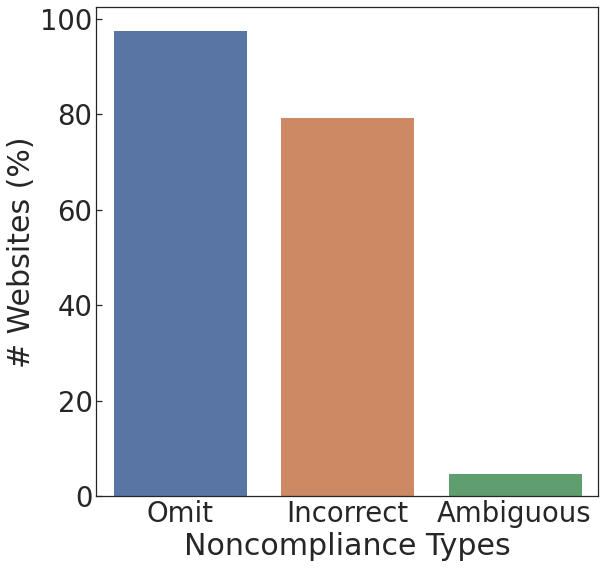

In [12]:
sns.set(rc={'figure.figsize':(9,9),"font.size":30,"axes.titlesize":30,"axes.labelsize":30},style="white", font_scale = 2.5)

ax = sns.barplot(x='comply_type', y='num_sites_percent', data=noncomply_sites)
ax.tick_params(left=True, bottom=True, direction="in")
ax.set_ylabel('# Websites (%)')
ax.set_xlabel('Noncompliance Types')
xticks = [x.get_text().title() for x in ax.get_xticklabels()]
ax.set(xticklabels=xticks)

out_file = fig_dir / 'noncomply_types_per_site.png'
# plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [13]:
omit_complies = complies[complies.comply == 'omit']
omit_complies.site.value_counts()

goal.com          97
download.com      90
zdnet.com         85
cnet.com          71
gamespot.com      65
                  ..
ssrn.com           1
irishtimes.com     1
exoclick.com       1
soundcloud.com     1
pardot.com         1
Name: site, Length: 81, dtype: int64

In [14]:
# set(cookielist_sites) - set(omit_complies.site.unique())

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/omit_site.png


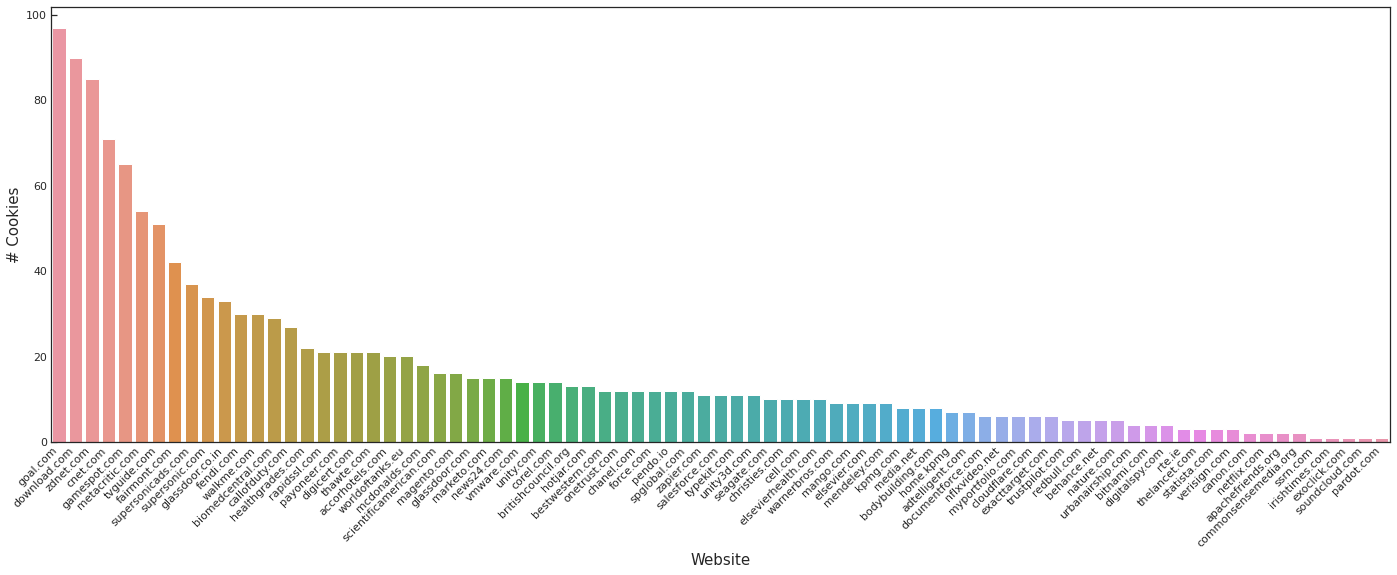

In [15]:
sns.set(rc={'figure.figsize':(24,8),"font.size":25,"axes.titlesize":25,"axes.labelsize":15},style="white", font_scale = 1)
omit_counts = omit_complies.site.value_counts()
ax = sns.barplot(x=omit_counts.index, y=omit_counts.values)
ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=False, direction="in")
ax.set_ylabel('# Cookies')
ax.set_xlabel('Website')

out_file = fig_dir / 'omit_site.png'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [16]:
def plot_histogram_omit():
    sns.set(rc={'figure.figsize':(9,6),"font.size":25,"axes.titlesize":25,"axes.labelsize":15},style="white", font_scale = 1)
    omit_counts_histo = omit_complies.site.value_counts().value_counts()
    sns.barplot(x=omit_counts_histo.index, y=omit_counts_histo.values)
    ticks = plt.xticks(rotation=45, ha='right')

In [17]:
omit_complies[omit_complies.site.isin({'ssrn.com', 'exoclick.com', 'pardot.com', 'irishtimes.com'})]
# omit_complies[omit_complies.site.isin({'metacritic.com'})]

,name,domain,site,comply
79425,_gcl_au,.exoclick.com,exoclick.com,omit
114199,_gcl_au,.irishtimes.com,irishtimes.com,omit
138960,_gat_gtag_UA_1824249_1,.pardot.com,pardot.com,omit
167652,CFTOKEN,www.ssrn.com,ssrn.com,omit


In [18]:
omit_complies.name.value_counts().head(10)

_gcl_au                  34
OptanonAlertBoxClosed    19
_gid                     15
_ga                      15
OptanonConsent           15
MR                       14
s_sq                     12
cohsn_xs_id              11
__cfduid                 10
chkChromeAb67Sec          8
Name: name, dtype: int64

In [19]:
# site_prefs[ site_prefs.site.isin(['exoclick.com', 'irishtimes.com']) & (site_prefs.name == '_gcl_au') ]
site_prefs[ site_prefs.site.isin(['exoclick.com']) ]

,duration,host,name,group_id,site,consent
5046,2914206 days,exoclick.com,eupubconsent,C0001,exoclick.com,True
5047,365 days,exoclick.com,OptanonAlertBoxClosed,C0001,exoclick.com,True
5048,365 days,exoclick.com,OptanonConsent,C0001,exoclick.com,True
5049,30 days,cookielaw.org,__cfduid,C0001,exoclick.com,True
5050,1 day,exoclick.com,_gid,C0002,exoclick.com,False
5051,730 days,exoclick.com,_ga,C0002,exoclick.com,False
5052,a few seconds,exoclick.com,_gat,C0002,exoclick.com,False
5053,180 days,youtube.com,VISITOR_INFO1_LIVE,C0004,exoclick.com,False
5054,6161 days,youtube.com,CONSENT,C0004,exoclick.com,False
5055,Session,youtube.com,YSC,C0004,exoclick.com,False


In [20]:
site_prefs[ site_prefs.name == '_gcl_au']

,duration,host,name,group_id,site,consent
361,75 days,.britishcouncil.org,_gcl_au,C0004,britishcouncil.org,False
1449,26 days,.mcdonalds.com,_gcl_au,C0004,mcdonalds.com,False
2182,31 days,vmware.com,_gcl_au,C0002,vmware.com,False
7323,90 days,pendo.io,_gcl_au,C0004,pendo.io,False


In [21]:
incor_complies = complies[complies.comply == 'incorrect']
# set(cookielist_sites) - set(omit_complies.site.unique())
incor_counts = incor_complies.site.value_counts()
incor_counts = incor_counts.to_frame().reset_index().sort_values(by=['site', 'index'], ascending=[False, True])
incor_counts.columns

Index(['index', 'site'], dtype='object')

Written to /home/ducbui/local_projects/consent/paper/sp22/figures/incor_site.png


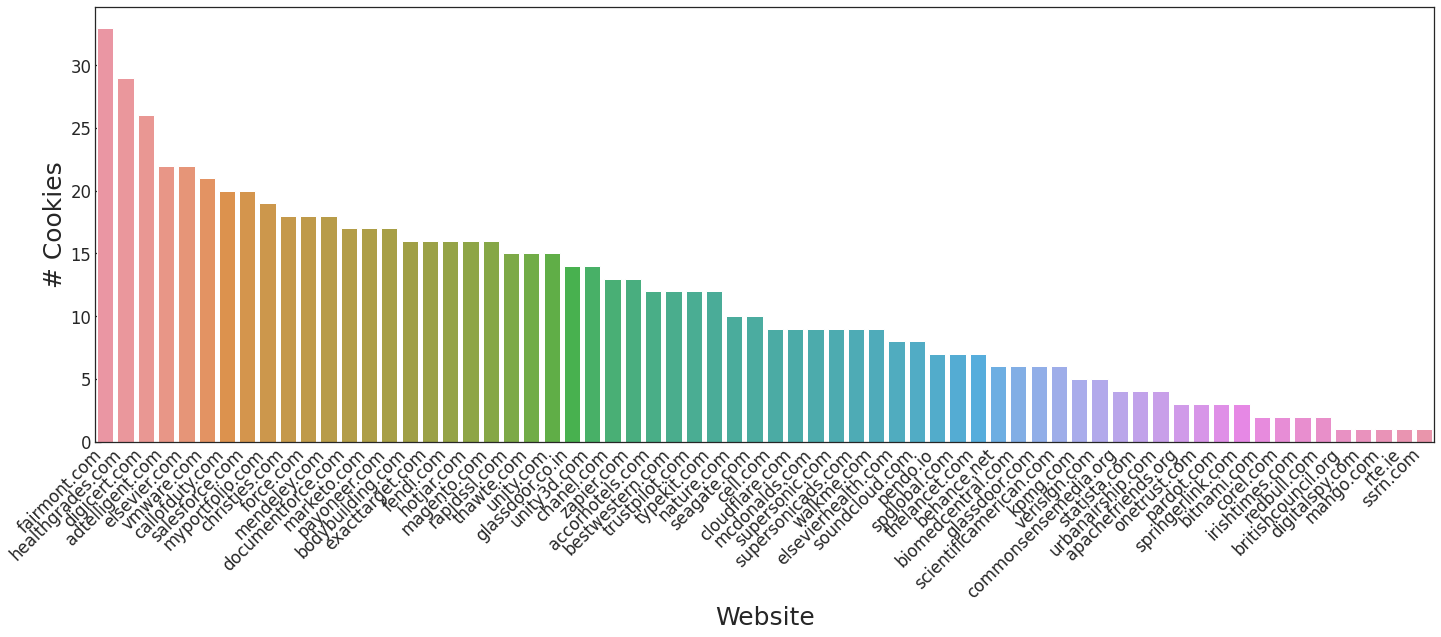

In [22]:
sns.set(rc={'figure.figsize':(24,8),"font.size":35,"axes.titlesize":35,"axes.labelsize":25},style="white", font_scale=1.5)
ax = sns.barplot(x='index', y='site', data=incor_counts)

ticks = plt.xticks(rotation=45, ha='right')

ax.tick_params(left=True, bottom=True, direction="in")
ax.set_ylabel('# Cookies')
ax.set_xlabel('Website')

out_file = fig_dir / 'incor_site.png'
plt.savefig(out_file, dpi=200, bbox_inches='tight'); print(f"Written to {out_file}")

In [23]:
# len(incor_counts)

In [24]:
incor_counts[incor_counts.site == 33].reset_index(drop=True)

,index,site
0,fairmont.com,33


In [25]:
u_complies = full_complies[ (full_complies.site == 'urbanairship.com') & (full_complies.comply == 'omit') ][['domain', 'name', 'value', 'site', 'comply']].drop_duplicates()
u_complies.sort_values('name').reset_index(drop=True)

,domain,name,value,site,comply
0,.airship.com,_biz_pendingA,%5B%5D,urbanairship.com,omit
1,.airship.com,_biz_sid,80a282,urbanairship.com,omit
2,.airship.com,_biz_uid,1d52e162f4304764f00eaf9b4f4cfb63,urbanairship.com,omit
3,.airship.com,_mkto_trk,id:313-QPJ-195&token:_mch-airship.com-16200916...,urbanairship.com,omit


In [26]:
a_complies = full_complies[ (full_complies.site == 'fairmont.com') & (full_complies.comply == 'incorrect') ][['domain', 'name', 'value', 'site', 'comply']].drop_duplicates()
a_complies.sort_values('name').reset_index(drop=True)

,domain,name,value,site,comply
0,www.fairmont.com,EktGUID,ebeb7b4b-d207-4f6c-9969-4ade91b0a114,fairmont.com,incorrect
1,.doubleclick.net,IDE,AHWqTUkIu_XsyvXdEkM9vSgUIunjHB2Ll7lHGkH9zoLyEc...,fairmont.com,incorrect
2,.tripadvisor.com,ServerPool,C,fairmont.com,incorrect
3,.www.tripadvisor.com,TADCID,Gb15f8VlCk1N-HlKABQCOOZxN9dDTFOGPRc8ZKnZH2U8hZ...,fairmont.com,incorrect
4,.tripadvisor.com,TAUnique,%1%enc%3Agp7wku6kNu7FdygSmpvz8SpTq5w4yLE%2BZ2O...,fairmont.com,incorrect
5,.fairmont.com,__qca,P0-921597735-1620091657312,fairmont.com,incorrect
6,.fairmont.com,__utma,76516226.681335714.1620091654.1620091654.16200...,fairmont.com,incorrect
7,.fairmont.com,__utmb,76516226.16.9.1620091710383,fairmont.com,incorrect
8,.fairmont.com,__utmb,76516226.11.9.1620091710383,fairmont.com,incorrect
9,.fairmont.com,__utmb,76516226.15.9.1620091710383,fairmont.com,incorrect


In [27]:
a_cookies = a_complies.name.tolist()
site_prefs[ (site_prefs.site == 'fairmont.com') & (site_prefs.name.isin(a_cookies)) ].sort_values('group_id')

,duration,host,name,group_id,site,consent
3784,a few seconds,www.fairmont.com,EktGUID,C0002,fairmont.com,False
3809,Session,ws.sessioncam.com,sc.ASP.NET_SESSIONID,C0002,fairmont.com,False
3808,a few seconds,fairmont.com,s_visit,C0002,fairmont.com,False
3807,a few seconds,fairmont.com,_gid,C0002,fairmont.com,False
3805,a few seconds,fairmont.com,s_fid,C0002,fairmont.com,False
3804,Session,fairmont.com,s_cc,C0002,fairmont.com,False
3802,a few seconds,fairmont.com,s_vnum,C0002,fairmont.com,False
3801,Session,fairmont.com,s_ppv,C0002,fairmont.com,False
3800,Session,fairmont.com,__utmc,C0002,fairmont.com,False
3799,a few seconds,fairmont.com,_ga_WPLEEQEV59,C0002,fairmont.com,False


In [28]:
full_complies[ (full_complies.site == 'onetrust.com') & (full_complies.comply == 'incorrect') ][['domain', 'name', 'value', 'site', 'comply']].drop_duplicates()


,domain,name,value,site,comply
136803,.linkedin.com,lidc,"""b=VGST05:s=V:r=V:a=V:p=V:g=2196:u=1:i=1620091...",onetrust.com,incorrect
137207,.linkedin.com,bcookie,"""v=2&04712d49-d35e-4cf8-858f-550c2bead280""",onetrust.com,incorrect
137561,.linkedin.com,UserMatchHistory,AQJjjF0MrWXwrwAAAXk0_wFhhVjK101jtI4-AatCq8neU_...,onetrust.com,incorrect


In [29]:
postrej_sent_cookies[ (postrej_sent_cookies.site == 'onetrust.com') & (postrej_sent_cookies.name == '_ga')]

,domain,expires,name,path,sameSite,secure,value,request_url,site
403978,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/themes/one...,onetrust.com
403990,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/uploads/20...,onetrust.com
404013,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/themes/one...,onetrust.com
404028,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/uploads/20...,onetrust.com
404029,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/themes/one...,onetrust.com
...,...,...,...,...,...,...,...,...,...
408967,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/uploads/20...,onetrust.com
408970,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/themes/one...,onetrust.com
408984,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/themes/one...,onetrust.com
409012,.onetrust.com,1.683164e+09,_ga,/,None,False,GA1.2.48635262.1620091798,https://www.onetrust.com/wp-content/uploads/20...,onetrust.com


In [30]:
# site_prefs[ (site_prefs.site == 'glassdoor.co.in') & (site_prefs.name.str.contains('_gat')) ]
# site_prefs[ (site_prefs.site == 'glassdoor.com') & (site_prefs.name.str.contains('gdId')) ]
site_prefs[ (site_prefs.site == 'onetrust.com') ]

,duration,host,name,group_id,site,consent
5318,Session,www.onetrust.com,OneTrustConsent,1,onetrust.com,True
5319,1 year,onetrust.com,OptanonConsent,1,onetrust.com,True
5320,a few seconds,onetrust.com,__cfduid,1,onetrust.com,True
5321,1 year,onetrust.com,OptanonAlertBoxClosed,1,onetrust.com,True
5322,Session,my.onetrust.com,pctrk,1,onetrust.com,True
5323,a few seconds,www.onetrust.com,_dc_gtm_UA-xxxxxxxx,1,onetrust.com,True
5324,20 days,preferencechoice.com,__cfduid,1,onetrust.com,True
5325,2 years,www.onetrust.com,_ga,2,onetrust.com,False
5326,a few seconds,onetrust.com,_gat_UA-nnnnnnn-nn,2,onetrust.com,False
5327,2 years,www.onetrust.com,__utma,2,onetrust.com,False


In [31]:
complies[complies.comply == 'ambiguous'] # TODO: why glassdoor.co.in not appear in the warning?

,name,domain,site,comply
105054,_gat_UA-2595786-1,.glassdoor.co.in,glassdoor.co.in,ambiguous
106696,G_ENABLED_IDPS,.www.glassdoor.com,glassdoor.com,ambiguous
106704,trs,www.glassdoor.com,glassdoor.com,ambiguous
106705,gdId,www.glassdoor.com,glassdoor.com,ambiguous
133368,fg,.adobe.com,myportfolio.com,ambiguous
133479,feds_visitor_id,.adobe.com,myportfolio.com,ambiguous
133480,feds_visitor_audience,.adobe.com,myportfolio.com,ambiguous
133610,ak_bmsc,.adobe.com,myportfolio.com,ambiguous
179416,fg,.adobe.com,typekit.com,ambiguous
179495,feds_visitor_audience,.adobe.com,typekit.com,ambiguous


In [32]:
contra_pref_data = defaultdict(list)
for site, contra_set in site_to_contras.items():
    for contra in contra_set:
        contra_pref_data['site'].append(site)
        for attr, val in contra.items():
            contra_pref_data[attr].append(val)
contra_prefs = pd.DataFrame(contra_pref_data)
contra_prefs

,site,host,name
0,accorhotels.com,ibis.accor.com,GoogleAdServingTest
1,accorhotels.com,restaurants.accor.com,GoogleAdServingTest
2,accorhotels.com,mercure.accor.com,GoogleAdServingTest
3,accorhotels.com,sofitel.accor.com,GoogleAdServingTest
4,accorhotels.com,pullman.accor.com,GoogleAdServingTest
5,accorhotels.com,google.com,NID
6,accorhotels.com,all.accor.com,GoogleAdServingTest
7,accorhotels.com,hotelf1.accor.com,GoogleAdServingTest
8,cell.com,hubspot.net,__cfduid
9,fairmont.com,google.com,NID


In [33]:
print(f"Num websites with contra prefs: {contra_prefs.site.nunique()}")
print(f"Num cookie with contra prefs: {len(contra_prefs)}")

Num websites with contra prefs: 11
Num cookie with contra prefs: 20


In [34]:
site_to_contras = {site: contras for site, contras in site_to_contras.items() if len(contras) > 0}
site_to_contras

{'accorhotels.com': {{'host': 'all.accor.com', 'name': 'GoogleAdServingTest'},
  {'host': 'google.com', 'name': 'NID'},
  {'host': 'hotelf1.accor.com', 'name': 'GoogleAdServingTest'},
  {'host': 'ibis.accor.com', 'name': 'GoogleAdServingTest'},
  {'host': 'mercure.accor.com', 'name': 'GoogleAdServingTest'},
  {'host': 'pullman.accor.com', 'name': 'GoogleAdServingTest'},
  {'host': 'restaurants.accor.com', 'name': 'GoogleAdServingTest'},
  {'host': 'sofitel.accor.com', 'name': 'GoogleAdServingTest'}},
 'cell.com': {{'host': 'hubspot.net', 'name': '__cfduid'}},
 'fairmont.com': {{'host': 'google.com', 'name': 'CONSENT'},
  {'host': 'google.com', 'name': 'NID'}},
 'glassdoor.com': {{'host': 'glassdoor.com', 'name': 'dc'}},
 'myportfolio.com': {{'host': 'app-aba.marketo.com', 'name': '__cf_bm'}},
 'oclc.org': {{'host': 'youtube.com', 'name': 'GPS'}},
 'statista.com': {{'host': 'm6r.eu', 'name': 'id'}},
 'thelancet.com': {{'host': 'hubspot.com', 'name': '__cfduid'}},
 'typekit.com': {{'host

In [35]:
site_prefs[ (site_prefs.site == 'glassdoor.co.in') & (site_prefs.name.str.contains('_gat_UA-2595786-1')) ]

,duration,host,name,group_id,site,consent
10899,Session,Glassdoor,_gat_UA-2595786-1,C0001,glassdoor.co.in,True
10910,a few seconds,glassdoor.co.in,_gat_UA-2595786-1,C0002,glassdoor.co.in,False


In [36]:
site_prefs[ (site_prefs.site == 'oclc.org') & (site_prefs.name.str.contains('GPS')) ]

,duration,host,name,group_id,site,consent
7456,365 days,youtube.com,GPS,C0001,oclc.org,True
7494,a few seconds,youtube.com,GPS,C0004,oclc.org,False


In [37]:
site_prefs[ (site_prefs.site == 'netflix.com') & (site_prefs.name.str.contains('flwssn')) ]

,duration,host,name,group_id,site,consent
10178,a few seconds,netflix.com,flwssn,C0001,netflix.com,True


In [38]:
complies[complies.site == 'netflix.com']

,name,domain,site,comply
135842,NetflixId,.netflix.com,netflix.com,comply
135843,SecureNetflixId,.netflix.com,netflix.com,comply
135844,OptanonAlertBoxClosed,.netflix.com,netflix.com,comply
135847,clSharedContext,.netflix.com,netflix.com,comply
135848,flwssn,.netflix.com,netflix.com,comply
135849,nflx_tags_fb_simplicity_nmLanding,ae.nflximg.net,netflix.com,omit
135852,memclid,.netflix.com,netflix.com,comply
135855,nfvdid,.netflix.com,netflix.com,comply
135880,cL,.www.netflix.com,netflix.com,comply
135897,XSRF-TOKEN,.help.netflix.com,netflix.com,comply


In [39]:
postrej_sent_cookies[ (postrej_sent_cookies.site == 'netflix.com') & (postrej_sent_cookies.name == 'flwssn')]

,domain,expires,name,path,sameSite,secure,value,request_url,site
671180,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://www.netflix.com/personalization/cl2/fr...,netflix.com
671183,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://www.netflix.com/ichnaea/log,netflix.com
671188,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://www.netflix.com/personalization/cl2/fr...,netflix.com
671190,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://www.netflix.com/personalization/cl2/fr...,netflix.com
671200,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://ichnaea-web.netflix.com/log,netflix.com
671203,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://www.netflix.com/personalization/log,netflix.com
671211,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://netflix.com/,netflix.com
671215,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://www.netflix.com/personalization/cl2,netflix.com
671231,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://help.netflix.com/en/api/notifications,netflix.com
671241,.netflix.com,1.620103e+09,flwssn,/,None,False,74410f8c-4356-45e0-ab30-87a9c239b7a5,https://help.netflix.com/legal/notices,netflix.com


In [40]:
# complies[ complies.comply == 'incorrect' ].iloc[50:100]

In [41]:
complies[ complies.comply == 'incorrect' ].domain.nunique()

120

In [42]:
url_domain_match('https://www.healthgrades.com/content/cookie-policy', '.healthgrades.com')

True

In [43]:
site_prefs[ (site_prefs.site == 'salesforce.com') & (site_prefs.name.str.contains('optimizely')) ]

,duration,host,name,group_id,site,consent
5544,365 days,salesforce.com,optimizelyOptOut,3,salesforce.com,False
5548,365 days,salesforce.com,optimizelyPPID,3,salesforce.com,False
5572,365 days,www.salesforce.com,optimizelyDomainTestCookie,3,salesforce.com,False
5577,a few seconds,salesforce.com,optimizelyRedirectData,3,salesforce.com,False
5632,3650 days,salesforce.com,optimizelyEndUserId,3,salesforce.com,False
5651,Session,rum.optimizely.com,optimizelyRumLB,3,salesforce.com,False


In [44]:
tcf_sites_file = Path('/home/ducbui/Dropbox/projects/optout/data/2021-03-07/tcf_topsites/tcf_sites.json')
tcf_sites = pd.read_json(tcf_sites_file)
tcf_domains = set(tcf_sites.domain.tolist())

In [45]:
set(complies.site.unique()).intersection(tcf_domains)

{'digitalspy.com'}

In [46]:
complies[complies.site == 'digitalspy.com']

,name,domain,site,comply
53474,eupubconsent-v2,.digitalspy.com,digitalspy.com,comply
53475,_hrstCID,.digitalspy.com,digitalspy.com,omit
53476,OptanonAlertBoxClosed,.digitalspy.com,digitalspy.com,comply
53479,location_data,digitalspy.com,digitalspy.com,comply
53480,location_data,www.digitalspy.com,digitalspy.com,omit
53481,_ga,.digitalspy.com,digitalspy.com,comply
53483,AMP_TOKEN,.digitalspy.com,digitalspy.com,comply
53484,OTAdditionalConsentString,.digitalspy.com,digitalspy.com,omit
53487,_HFID,www.digitalspy.com,digitalspy.com,incorrect
53488,_HFID,digitalspy.com,digitalspy.com,omit


In [47]:
set(complies.site.unique()) - set(complies[complies.comply == 'comply'].site.unique())

set()